# Seminar: Exploratory Data Analysis in Python/Pandas environment

* We will explore and understand the **Ames Housing dataset** of real estate sales
* The content is based on the Kaggle Competition House Prices Advanced Regression Techniques. See details [here](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

## Definitions

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

## Task 1: Read data and undestand it's structure

### 1a. Load training dataset (in `./data/train.csv`) and display 5 random rows

Hint: Use `.style` attribute to display all columns

Hint: See  `./data/data_description.txt` for documentation of variables

In [2]:
df = pd.read_csv('./data/train.csv', index_col='Id')
df.sample(5).style

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
866,20,RL,nan,8750,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1970,1970,Gable,CompShg,MetalSd,MetalSd,BrkFace,76.000000,TA,TA,CBlock,TA,TA,No,BLQ,828,Unf,0,174,1002,GasA,TA,Y,SBrkr,1002,0,0,1002,1,0,1,0,3,1,TA,5,Typ,0,nan,Detchd,1973.000000,Unf,2,902,TA,TA,Y,0,0,0,0,0,0,nan,MnPrv,nan,0,8,2009,WD,Normal,148500
600,160,RM,24.000000,1950,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Blueste,Norm,Norm,Twnhs,2Story,6,6,1980,1980,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,Gd,CBlock,Gd,TA,No,LwQ,81,GLQ,612,23,716,GasA,TA,Y,SBrkr,716,840,0,1556,1,0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1980.000000,Fin,2,452,TA,TA,Y,161,0,0,0,0,0,nan,GdPrv,nan,0,7,2008,COD,Normal,151000
1154,30,RM,nan,5890,Pave,nan,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,6,8,1930,2007,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.000000,Gd,Gd,BrkTil,TA,TA,Av,ALQ,538,Unf,0,278,816,GasA,Ex,Y,SBrkr,816,0,0,816,0,0,1,0,2,1,TA,5,Typ,0,nan,Detchd,2002.000000,Unf,1,432,TA,TA,Y,0,0,96,0,0,0,nan,nan,nan,0,6,2008,WD,Normal,120500
668,20,RL,65.000000,8125,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,6,5,1994,1998,Gable,CompShg,HdBoard,HdBoard,BrkFace,258.000000,TA,TA,PConc,Gd,TA,No,GLQ,1138,Unf,0,270,1408,GasA,Ex,Y,SBrkr,1679,0,0,1679,1,0,2,0,3,1,Gd,7,Typ,1,Fa,Attchd,1994.000000,RFn,2,575,TA,TA,Y,224,42,0,0,0,0,nan,nan,nan,0,10,2008,WD,Normal,193500
740,60,RL,65.000000,9313,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,None,0.000000,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,864,864,GasA,Ex,Y,SBrkr,864,864,0,1728,0,0,2,1,3,1,Gd,7,Typ,0,nan,Attchd,2004.000000,RFn,2,572,TA,TA,Y,187,56,0,0,0,0,nan,nan,nan,0,4,2009,WD,Normal,190000


### 1b. What is the distribution `SalePrice` variable?

* plot histogram (`.hist()` on `pd.Series`) with bin width $10,000

Hint: Specify bins using range

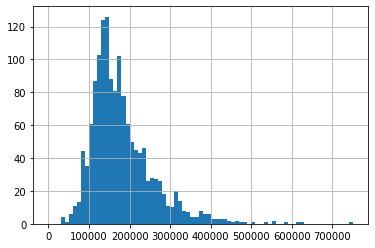

In [3]:
df.SalePrice.hist(bins=range(0,df.SalePrice.max(),10000))

### 1c. Split columns between quantitative and qualitative variables
Store column names in separate lists of strings `quantitative` and `qualitative`

Hint: `.dtypes` attribute contains a series with strings describing dtype of the data

In [4]:
qualitative = [column for column in df.columns if df.dtypes[column] == 'object']

quantitative = [column for column in df.columns if df.dtypes[column] != 'object']

print(qualitative)
print(quantitative)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'Enclos

### 1d. Are `dtype`s correct? 

In [5]:
df[qualitative].sample(10).style

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
60,RL,Pave,nan,Reg,Bnk,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,None,TA,TA,CBlock,TA,TA,Av,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,nan,Detchd,Unf,TA,TA,Y,nan,MnPrv,nan,WD,Normal
142,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,nan,Attchd,Fin,TA,TA,Y,nan,nan,nan,WD,Normal
554,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,nan,nan,nan,nan,nan,GasA,Ex,Y,SBrkr,Gd,Typ,nan,Detchd,Fin,TA,TA,N,nan,MnPrv,nan,WD,Normal
800,RL,Pave,nan,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Feedr,Norm,1Fam,1.5Fin,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,BrkTil,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Detchd,Unf,TA,TA,Y,nan,MnPrv,nan,WD,Normal
235,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,nan,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,BuiltIn,Fin,TA,TA,Y,nan,nan,nan,WD,Normal
323,RL,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,Gable,CompShg,Plywood,Plywood,BrkFace,Gd,TA,CBlock,TA,TA,Gd,LwQ,ALQ,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,Fin,TA,TA,Y,nan,MnPrv,nan,WD,Normal
287,RL,Pave,nan,IR1,Bnk,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,TA,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,nan,GdPrv,nan,WD,Normal
1231,RL,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Feedr,RRAe,Duplex,1.5Fin,Shed,CompShg,Plywood,Plywood,None,TA,TA,CBlock,Gd,TA,No,GLQ,Rec,GasA,Ex,Y,SBrkr,TA,Typ,TA,BuiltIn,RFn,TA,TA,N,nan,nan,Gar2,WD,Normal
1131,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,WdShing,Plywood,None,TA,TA,BrkTil,TA,TA,No,BLQ,Unf,GasA,TA,Y,SBrkr,Gd,Min2,TA,Detchd,Unf,TA,TA,Y,nan,MnPrv,nan,WD,Normal


In [6]:
df[quantitative].sample(10).style

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1077,50,60.000000,10800,5,8,1936,1989,0.000000,626,0,170,796,1096,370,0,1466,0,1,2,0,3,1,7,1,1950.000000,2,566,436,21,0,0,0,0,500,4,2006,170000
1009,20,43.000000,12118,7,5,2004,2005,108.000000,0,0,1710,1710,1710,0,0,1710,0,0,2,0,3,1,7,1,2004.000000,2,550,100,48,0,0,180,0,0,4,2009,240000
175,20,47.000000,12416,6,5,1986,1986,132.000000,1398,208,0,1606,1651,0,0,1651,1,0,2,0,3,1,7,1,1986.000000,2,616,192,0,0,0,0,0,0,11,2008,184000
1039,160,21.000000,1533,4,6,1970,2008,0.000000,0,0,546,546,798,546,0,1344,0,0,1,1,3,1,6,1,nan,0,0,0,0,0,0,0,0,0,5,2009,97000
756,160,34.000000,3230,6,5,1999,1999,894.000000,381,0,348,729,742,729,0,1471,0,0,2,1,3,1,6,0,1999.000000,2,440,0,24,0,0,0,0,0,3,2009,172500
403,30,60.000000,10200,5,8,1940,1997,0.000000,0,0,672,672,672,0,0,672,0,0,1,0,2,1,4,0,1940.000000,1,240,168,0,0,0,0,0,0,8,2008,108000
87,60,122.000000,11911,6,5,2005,2005,0.000000,0,0,684,684,684,876,0,1560,0,0,2,1,3,1,6,1,2005.000000,2,400,100,38,0,0,0,0,0,3,2009,174000
950,20,78.000000,9360,6,7,1972,2006,0.000000,982,0,179,1161,1381,0,0,1381,1,0,1,1,3,1,5,1,1972.000000,2,676,0,0,0,0,0,0,0,3,2010,197500
310,20,90.000000,12378,9,5,2003,2004,0.000000,1274,0,622,1896,1944,0,0,1944,1,0,2,0,3,1,8,3,2003.000000,3,708,208,175,0,0,0,0,0,11,2006,360000


### 1e. Plot number of missing data for all columns
* You can drop columns with no missing data

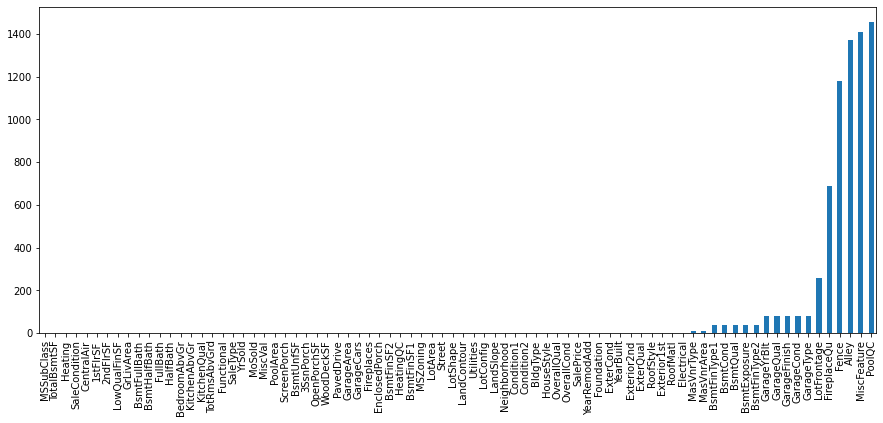

In [7]:
df.isna().sum().sort_values().plot.bar(figsize=(15, 6))

## Bonus: Distribution of all variables

### Quantitative


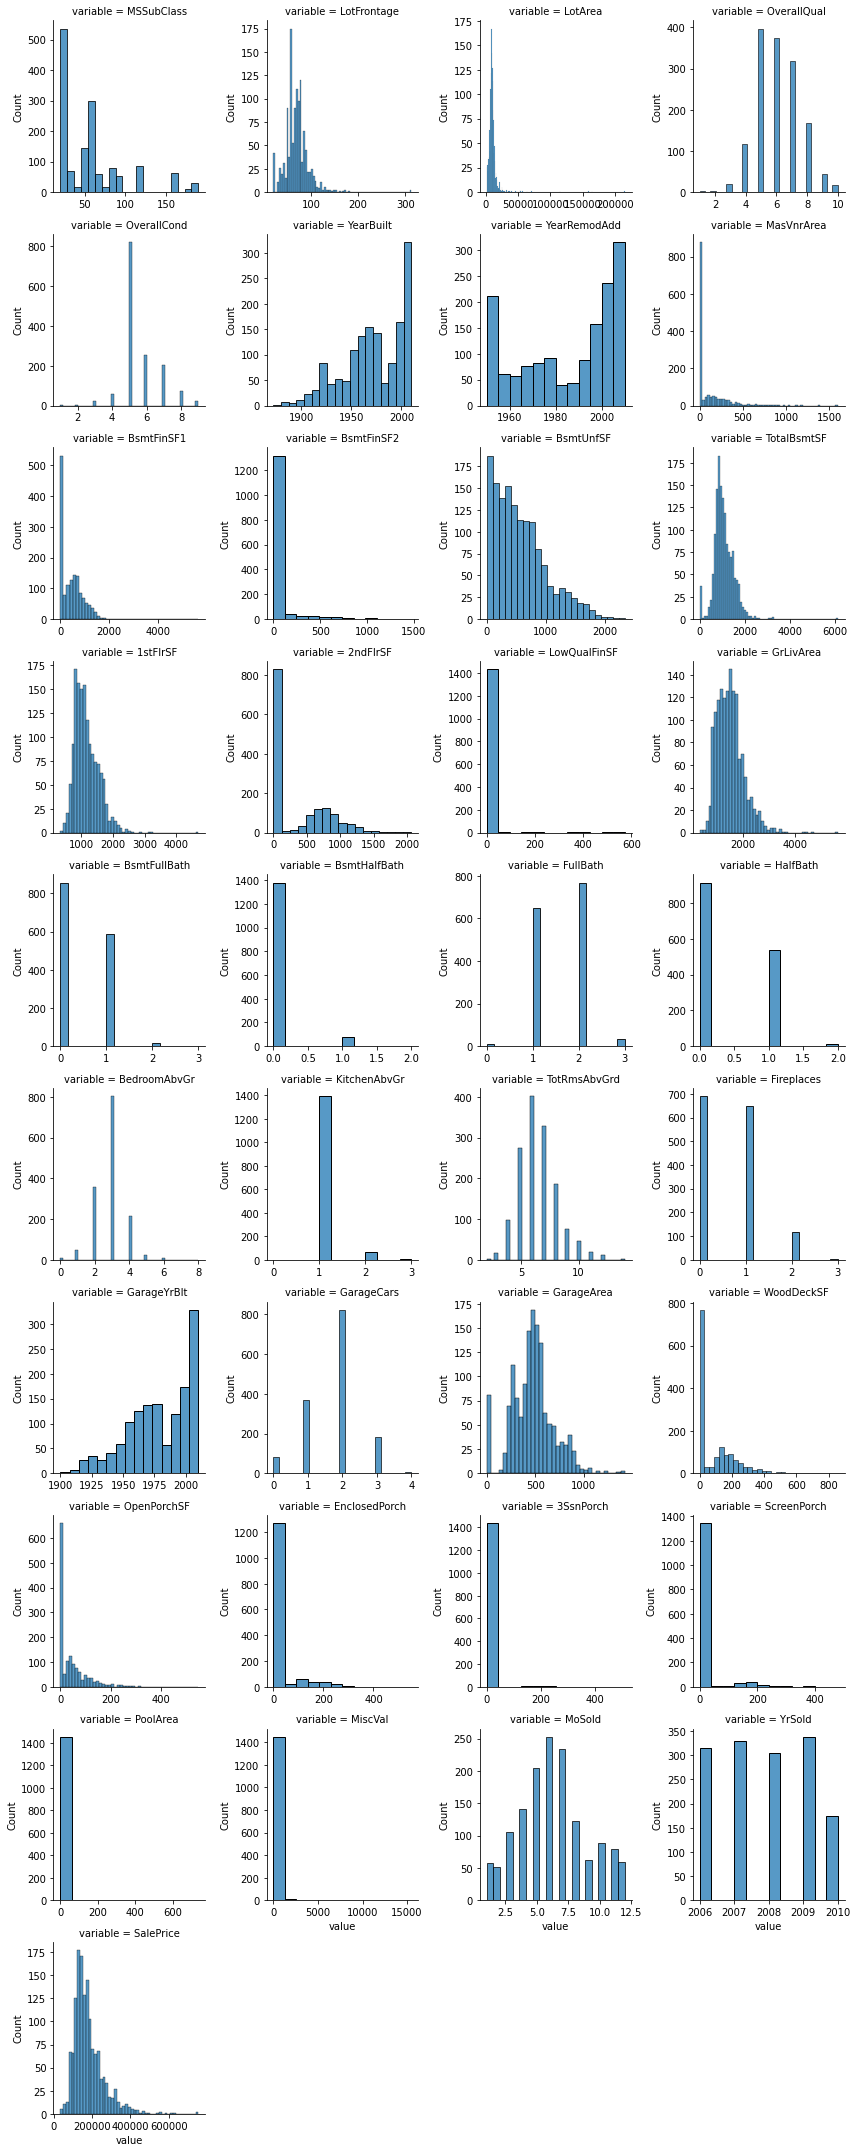

In [8]:
melted = pd.melt(df, value_vars=quantitative)
g = sns.FacetGrid(melted, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.histplot, "value")

### Quantitative

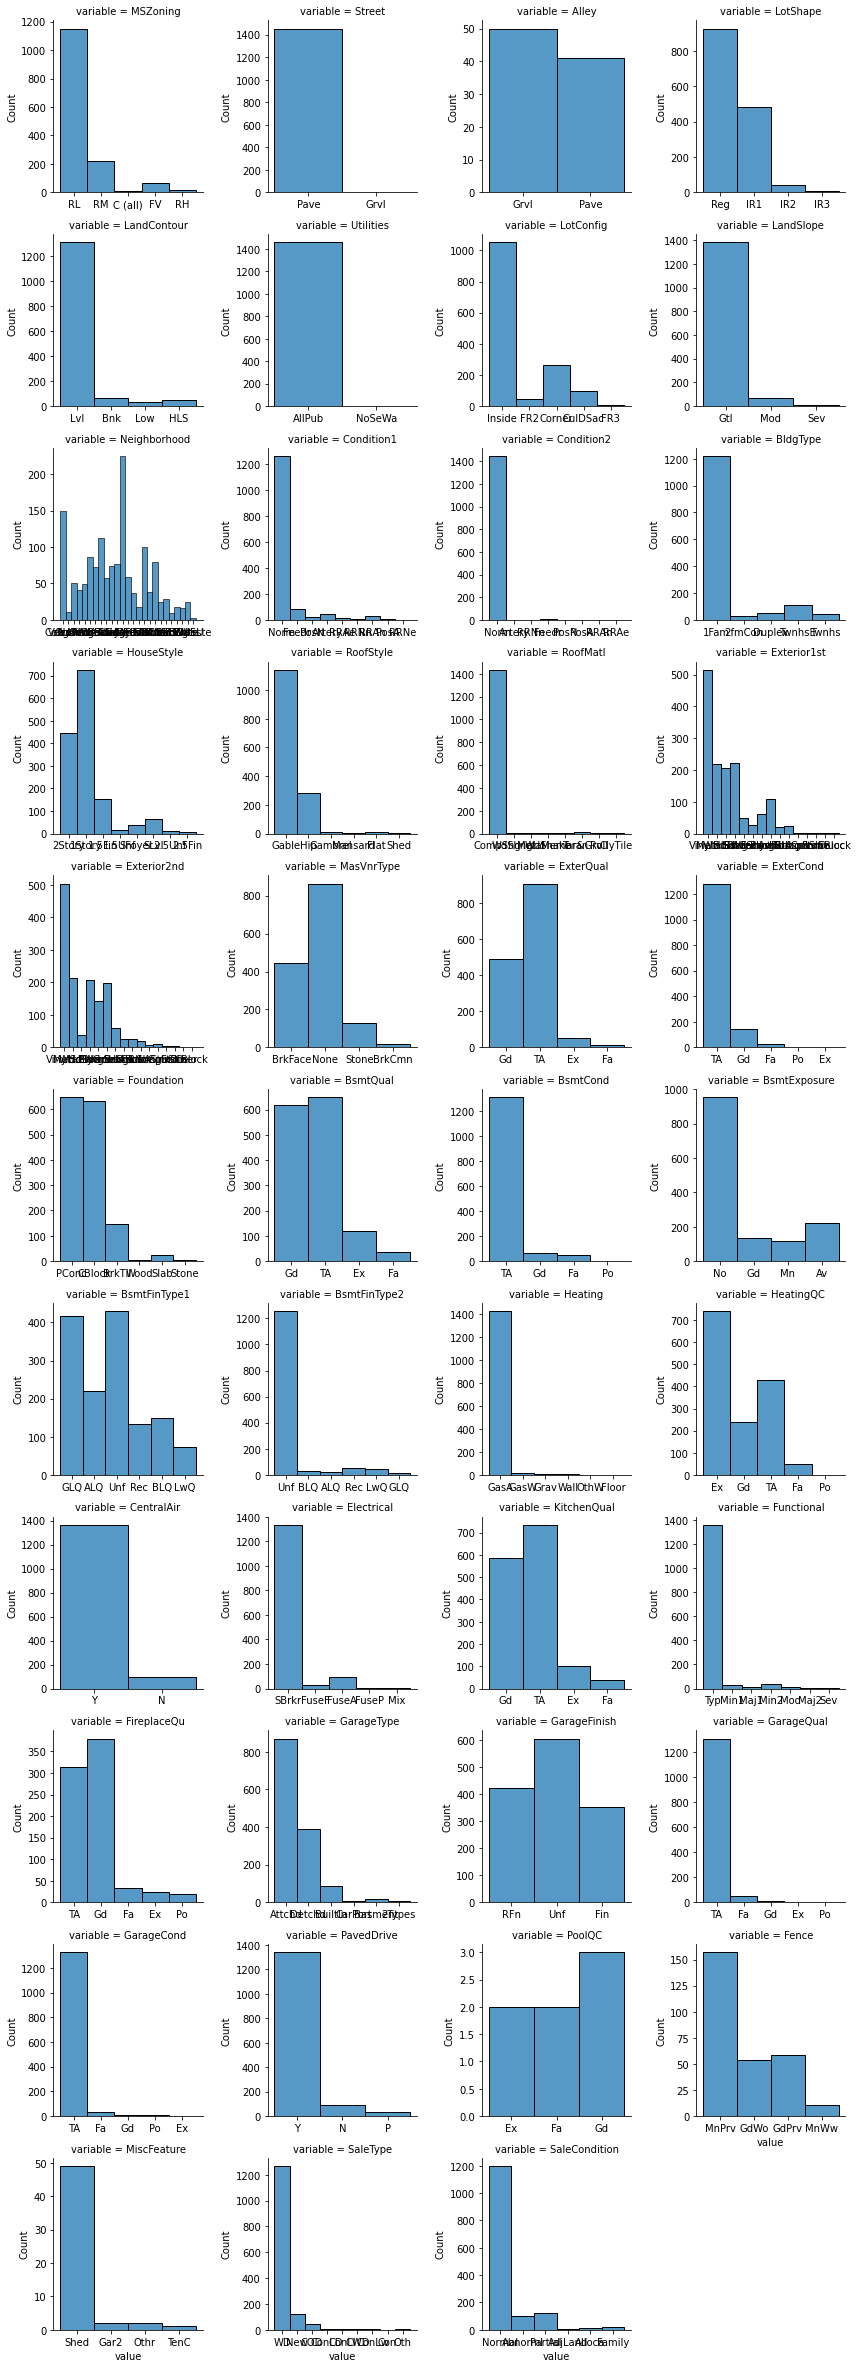

In [9]:
melted = pd.melt(df, value_vars=qualitative)
g = sns.FacetGrid(melted, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.histplot, "value")

## Task 2: Study relationships between variables

### 2a. see correlation matrix

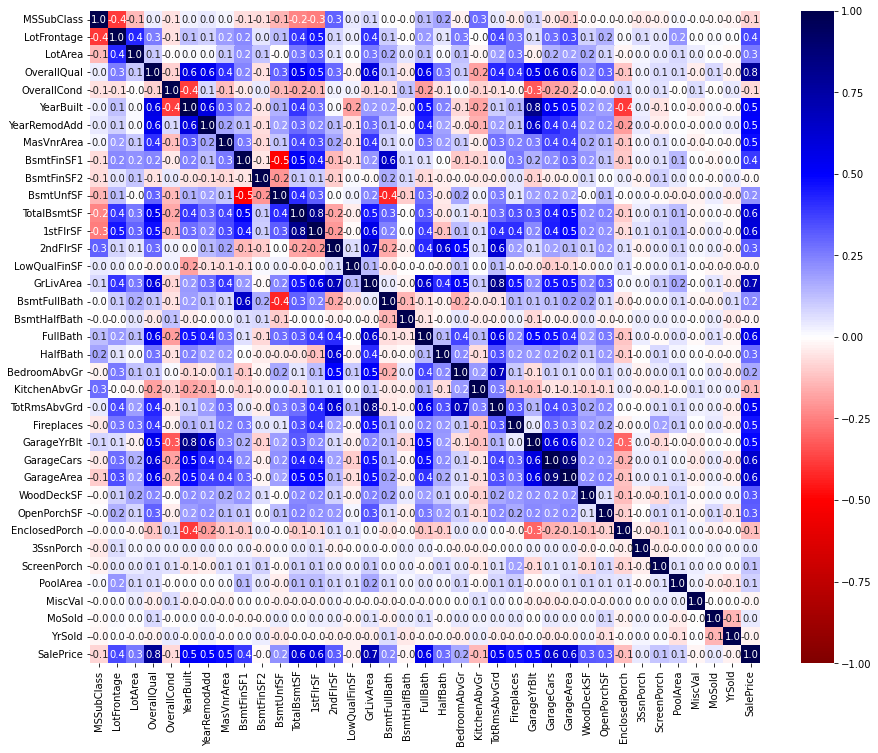

In [10]:
fig,ax=plt.subplots(1,1,figsize=(15,12))
sns.heatmap(df.corr(), ax=ax,vmin=-1,vmax=1,cmap='seismic_r',annot=True,fmt='0.1f')

### 2b. Boxplots for categorical variables

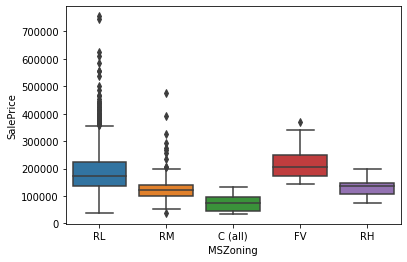

In [11]:
sns.boxplot(data=df,x='MSZoning',y='SalePrice')

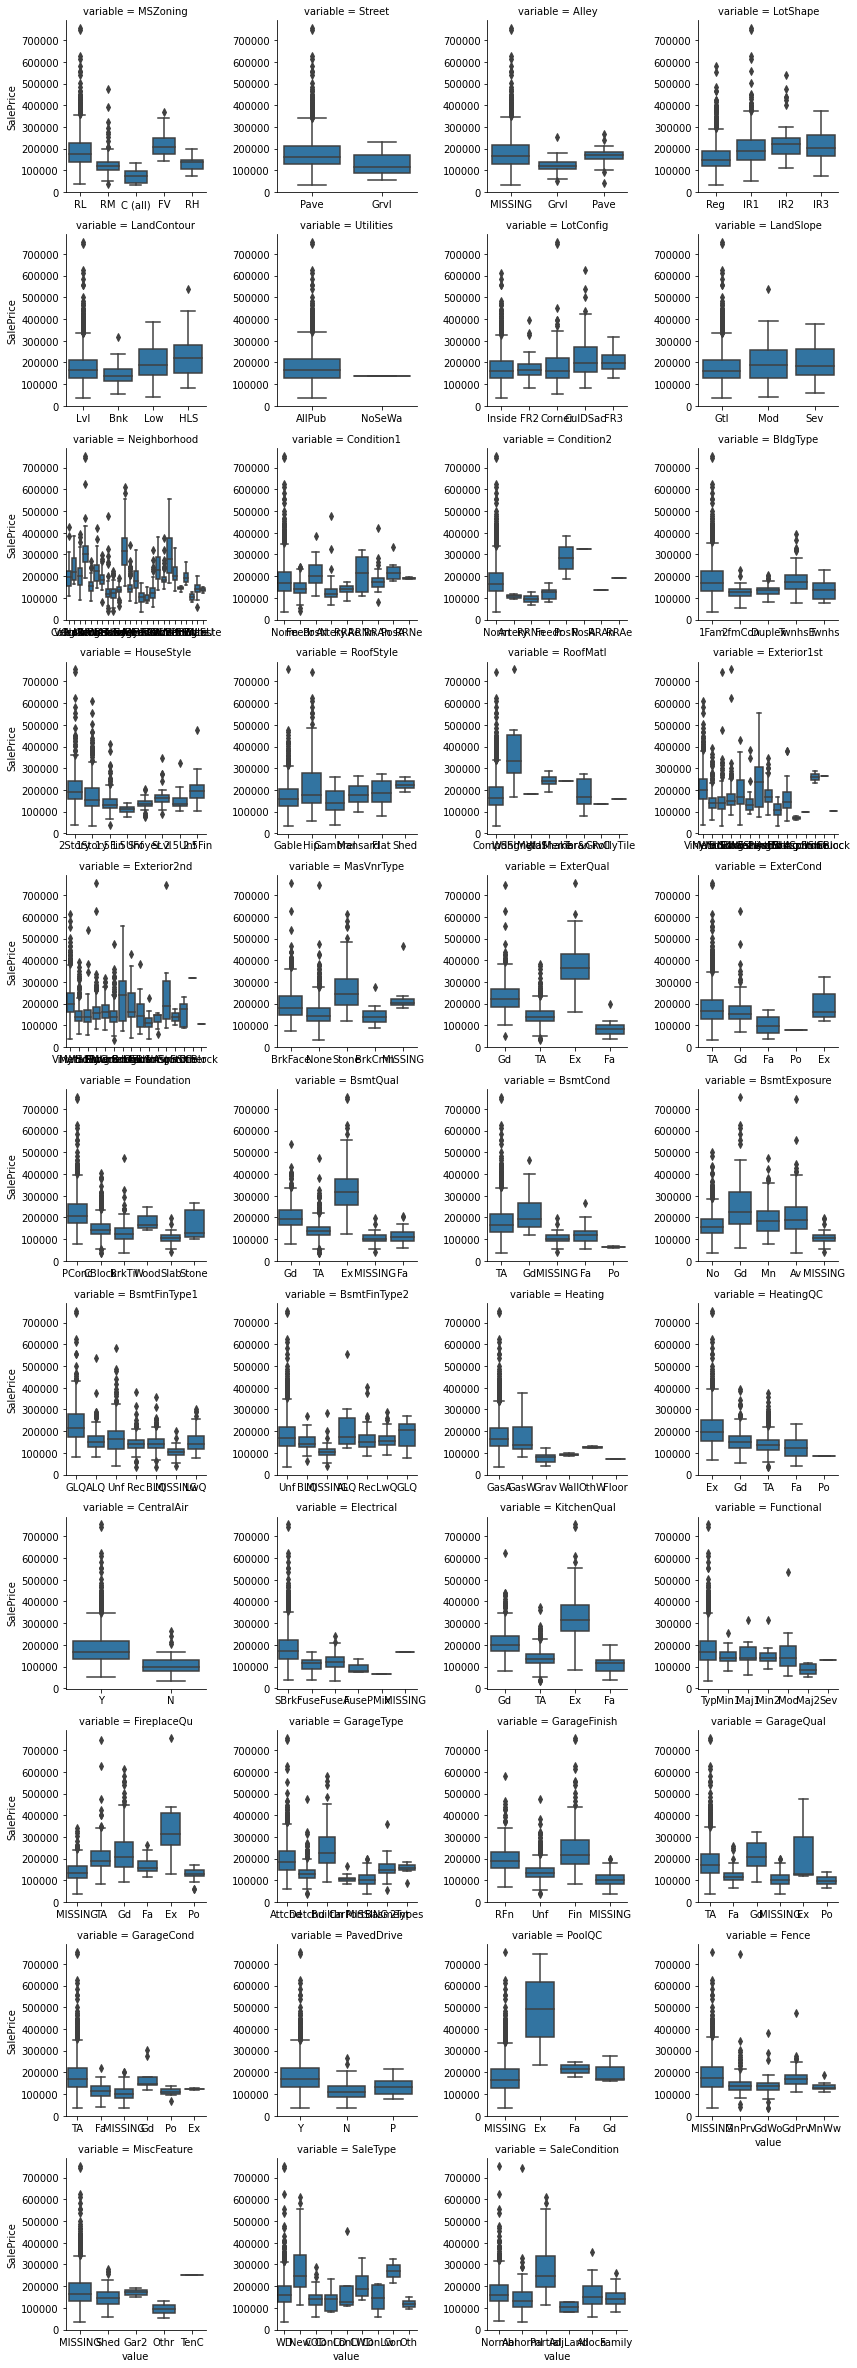

In [12]:
f = pd.melt(df.fillna('MISSING'), id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(lambda x,y,**kwargs: sns.boxplot(x=x, y=y, **kwargs), "value", "SalePrice")

## Task 3: ANOVA disparity estimations 

### One-way ANOVA 
* Question: Do sale prices differ across categories of certain feature?
* Test: Do price means across factors with a feature differ in their underlying distribution? 
* Are prices of houses with pool drawn from distribution with different mean than prices of house without a pool? 

* We will test this on all features and plot results

### 3a. Function for estimating ANOVA for one feature
* Your task is to complete a following snippet:


```python

 def anova_feature(qualitative_series, quantitative_series):
    '''
    Performs One-way ANOVA testing whether all levels of `qualitative` series are drawn from distributions with equal means

    Expects:
    - 'qualitative_series': Series with categorical data delienating indivudal groups
    - 'quantitative_series': Series with value data on which the distribution is tested
    
    Uses `scipy.stats.f_oneway` to deliver the test.

    Returns pd.Series with `statistic`, `p_value` and `disparity` measure. `statistic` and `p_value` are calculated by `scipy.stats.f_oneway`. Disparity is calculated as 1/log(p_value).
    '''
    samples =  {
        factor: quantitative_series.loc[qualitative_series.fillna('MISSING') == factor] for factor in qualitative_series.fillna('MISSING').unique()
    }

    anova_result =  stats.f_oneway(*samples.values())
    
    pass
```

In [13]:
def anova_feature(qualitative_series, quantitative_series):
    '''
    Performs One-way ANOVA testing whether `quantitative_series` across levels of `qualitative_series` are drawn from distributions with equal means

    Expects:
    - 'qualitative_series': Series with categorical data delienating indivudal groups
    - 'quantitative_series': Series with value data on which the distribution is tested
    

    Returns Series with test statistic, p-value
    '''
    samples =  {
        factor: quantitative_series.loc[qualitative_series.fillna('MISSING') == factor]for factor in qualitative_series.fillna('MISSING').unique()
    }

    statistic, pvalue =  stats.f_oneway(*samples.values())
    
    return pd.Series({
        'statistic':statistic,
        'p_value':pvalue,
        'disparity': math.log(1./pvalue)
    })

anova_feature(df.MasVnrType, df.SalePrice)

statistic    8.467220e+01
p_value      1.054025e-64
disparity    1.473128e+02
dtype: float64

### 3b. Generate dataframe with ANOVA test of all quantitative columns on `SalePrice` in the dataset

In [14]:
anova = pd.DataFrame({
    col: anova_feature(df[col],df.SalePrice) for col in qualitative
}).T
anova

,statistic,p_value,disparity
MSZoning,43.840282,8.817634e-35,78.413725
Street,2.459290,1.170486e-01,2.145166
Alley,15.176614,2.996380e-07,15.020691
LotShape,40.132852,6.447524e-25,55.700931
LandContour,12.850188,2.742217e-08,17.411914
Utilities,0.298804,5.847168e-01,0.536628
LotConfig,7.809954,3.163167e-06,12.663937
LandSlope,1.958817,1.413964e-01,1.956188
Neighborhood,71.784865,1.558600e-225,517.637858
Condition1,6.118017,8.904549e-08,16.234118


### 3c. Plot the disparity measure

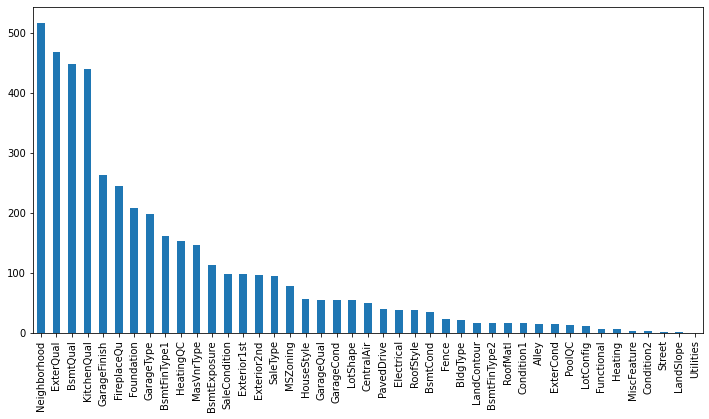

In [15]:
anova.disparity.sort_values(ascending=False).plot.bar(figsize=(12,6))

## Task 4: Encode qualitative variables as quantitative
### 4a. Feature-level function

* Write a function that  an input dataframe with encoded version
* Complete the following snippet

In [6]:
def encode_qualitative_feature(quantitative_series, qualitative_series, sorting_function=np.mean,suffix='_E'):
    '''
    Ranks `qualitative_series` according to sorting function applied on `quantitative_series` and return its rank as a series. 
    
    Series name is extended with `suffix`.
    '''
    encode_df = pd.DataFrame({
        quantitative_series.name:quantitative_series,
        qualitative_series.name:qualitative_series 
    })

    sorting = encode_df.groupby(qualitative_series.name)[quantitative_series.name].apply(np.mean).rank()

    return qualitative_series.map(sorting).rename(f'{qualitative_series.name}{suffix}')
encode_qualitative_feature(df.SalePrice, df.KitchenQual)

Id
1       3.0
2       2.0
3       3.0
4       3.0
5       3.0
       ... 
1456    2.0
1457    2.0
1458    3.0
1459    3.0
1460    2.0
Name: KitchenQual_E, Length: 1460, dtype: float64

## 4b. Apply on all qualitative features


In [7]:
def encode_columns(df, columns, sorting_function=np.mean,suffix='_E'):
    for col in columns:
        ranked_col = encode_qualitative_feature(df.SalePrice, df[col])
        df[ranked_col.name] = ranked_col

    return df

df_encoded =encode_columns(df.copy(), qualitative, sorting_function=np.mean,suffix='_E')
df_encoded

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,2.0,1.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,2.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,5.0,1.0,3.0,5.0,3.0,NaN,3.0,NaN,5.0,5.0
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,4.0,2.0,5.0,5.0


In [8]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
